# Knn evaluation

In [1]:
import os
import sys
import argparse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import torch
from torch import nn
import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchvision import transforms as pth_transforms
from torchvision import models as torchvision_models

import utils
import vision_transformer as vits

In [5]:
args = {}
args["batch_size_per_gpu"] = 32
args["nb_knn"] = [5, 10, 20, 30]
args["temperature"] = 0.07
args["pretrained_weights"] = ""
args["use_cuda"] = False
args["arch"] = "vit_small"
args["patch_size"] = 16
args["checkpoint_key"] = "teacher"
args["dump_features"] = "./data/features/"
args["suffix"] = "_shuffle_corrected"
args["load_features"] = None #"./data/features/"
args["save_features"] = "./data/features/"
args["num_workers"] = 4
args["dist_url"] = "env://"
args["local_rank"] = 0
args["data_path"] = "./data/tiny_imagenet/tiny-imagenet-200/"
args["rank"] = 0
args["gpu"] = 0
args["world_size "] = 1

In [6]:
print("\n".join("%s: %s" % (k, str(v)) for k, v in sorted(args.items())))
cudnn.benchmark = True

arch: vit_small
batch_size_per_gpu: 32
checkpoint_key: teacher
data_path: ./data/tiny_imagenet/tiny-imagenet-200/
dist_url: env://
dump_features: ./data/features/
gpu: 0
load_features: None
local_rank: 0
nb_knn: [5, 10, 20, 30]
num_workers: 4
patch_size: 16
pretrained_weights: 
rank: 0
save_features: ./data/features/
suffix: _shuffle_corrected
temperature: 0.07
use_cuda: False
world_size : 1


In [7]:
def extract_feature_pipeline(args):
    # ============ preparing data ... ============
    size = 224 # 256
    transform = pth_transforms.Compose([
        pth_transforms.Resize(size, interpolation=3),
        pth_transforms.CenterCrop(224),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    dataset_train = datasets.ImageFolder(root='./data/tiny_imagenet/tiny-imagenet-200/train/', transform=transform)
    dataset_val = datasets.ImageFolder(root='./data/tiny_imagenet/tiny-imagenet-200/val/', transform=transform)
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=args["batch_size_per_gpu"],
        num_workers=args["num_workers"],
        pin_memory=True,
        drop_last=False,
        shuffle=False                       # We are not training here!!
    )
    data_loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=args["batch_size_per_gpu"],
        num_workers=args["num_workers"],
        pin_memory=True,
        drop_last=False,
        shuffle=False
    )
    print(f"Data loaded with {len(dataset_train)} train and {len(dataset_val)} val imgs.")

    # ============ building network ... ============
    if "vit" in args["arch"]:
        model = vits.__dict__[args["arch"]](patch_size=args["patch_size"], num_classes=0)
        print(f"Model {args['arch']} {args['patch_size']}x{args['patch_size']} built.")
    else:
        print(f"Architecture {args['arch']} non supported")
        sys.exit(1)
    model.cuda()
    utils.load_pretrained_weights(model, args["pretrained_weights"], args["checkpoint_key"], args["arch"], args["patch_size"])
    model.eval()

    # ============ extract features ... ============
    print("Extracting features for train set...")
    train_features = extract_features(model, data_loader_train, args["use_cuda"])
    print("Extracting features for val set...")
    test_features = extract_features(model, data_loader_val, args["use_cuda"])
    
    train_features = nn.functional.normalize(train_features, dim=1, p=2)
    test_features = nn.functional.normalize(test_features, dim=1, p=2)

    train_labels = torch.tensor([s[-1] for s in dataset_train.samples]).long()
    test_labels = torch.tensor([s[-1] for s in dataset_val.samples]).long()
    # save features and labels
    if args["dump_features"]:
        torch.save(train_features.cpu(), os.path.join(args["dump_features"], "trainfeat" + args["suffix"] + ".pth"))
        torch.save(test_features.cpu(), os.path.join(args["dump_features"], "testfeat" + args["suffix"] + ".pth"))
        torch.save(train_labels.cpu(), os.path.join(args["dump_features"], "trainlabels" + args["suffix"] + ".pth"))
        torch.save(test_labels.cpu(), os.path.join(args["dump_features"], "testlabels" + args["suffix"] + ".pth"))
    return train_features, test_features, train_labels, test_labels

@torch.no_grad()
def extract_features(model, data_loader, use_cuda=True):
    metric_logger = utils.MetricLogger(delimiter="  ")
    features = None
    i = 0
    for samples, index in metric_logger.log_every(data_loader, 100):
        samples = samples.cuda(non_blocking=True)
        index = index.cuda(non_blocking=True)

        batch_size = samples.shape[0]
        idx = torch.arange(start=i*batch_size, end=(i + 1) * batch_size)
        i += 1
        
        feats = model(samples).clone()

        # init storage feature matrix
        if features is None:
            features = torch.zeros(len(data_loader.dataset), feats.shape[-1])
            if use_cuda:
                features = features.cuda(non_blocking=True)
            print(f"Storing features into tensor of shape {features.shape}")

        # update storage feature matrix
        if use_cuda:
            #features.index_copy_(0, index, feats)
            features.index_copy_(0, idx, feats)
        else:
            #features.index_copy_(0, index.cpu(), feats.cpu())
            features.index_copy_(0, idx.cpu(), feats.cpu())
    return features

In [8]:
if args["load_features"]:
    train_features = torch.load(os.path.join(args["load_features"], "trainfeat" + args["suffix"] + ".pth"))
    test_features = torch.load(os.path.join(args["load_features"], "testfeat" + args["suffix"] + ".pth"))
    train_labels = torch.load(os.path.join(args["load_features"], "trainlabels" + args["suffix"] + ".pth"))
    test_labels = torch.load(os.path.join(args["load_features"], "testlabels" + args["suffix"] + ".pth"))
else:
    # need to extract features !
    train_features, test_features, train_labels, test_labels = extract_feature_pipeline(args)

Data loaded with 100000 train and 10000 val imgs.
Model vit_small 16x16 built.
Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Extracting features for train set...
Storing features into tensor of shape torch.Size([100000, 384])
  [   0/3125]  eta: 10:13:48    time: 11.785139  data: 10.418344  max mem: 249
  [ 100/3125]  eta: 0:49:04    time: 1.341601  data: 0.000000  max mem: 249
  [ 200/3125]  eta: 1:23:22    time: 3.646104  data: 0.000000  max mem: 249
  [ 300/3125]  eta: 1:45:04    time: 3.675847  data: 0.000147  max mem: 249
  [ 400/3125]  eta: 1:53:35    time: 2.575461  data: 0.000000  max mem: 249
  [ 500/3125]  eta: 1:55:01    time: 3.708743  data: 0.000585  max mem: 249
  [ 600/3125]  eta: 1:57:23    time: 3.972012  data: 0.000000  max mem: 249


In [6]:
@torch.no_grad()
def knn_classifier(train_features, train_labels, test_features, test_labels, k, T, num_classes=200):
    top1, top5, total = 0.0, 0.0, 0
    train_features = train_features.t()
    num_test_images, num_chunks = test_labels.shape[0], 100
    imgs_per_chunk = num_test_images // num_chunks
    retrieval_one_hot = torch.zeros(k, num_classes).to(train_features.device)
    for idx in range(0, num_test_images, imgs_per_chunk):
        # get the features for test images
        features = test_features[idx : min((idx + imgs_per_chunk), num_test_images), :]
        targets = test_labels[idx : min((idx + imgs_per_chunk), num_test_images)]
        batch_size = targets.shape[0]

        # calculate the dot product and compute top-k neighbors
        similarity = torch.mm(features, train_features)
        distances, indices = similarity.topk(k, largest=True, sorted=True)
        candidates = train_labels.view(1, -1).expand(batch_size, -1)
        retrieved_neighbors = torch.gather(candidates, 1, indices)

        retrieval_one_hot.resize_(batch_size * k, num_classes).zero_()
        retrieval_one_hot.scatter_(1, retrieved_neighbors.view(-1, 1), 1)
        distances_transform = distances.clone().div_(T).exp_()
        probs = torch.sum(
            torch.mul(
                retrieval_one_hot.view(batch_size, -1, num_classes),
                distances_transform.view(batch_size, -1, 1),
            ),
            1,
        )
        _, predictions = probs.sort(1, True)

        # find the predictions that match the target
        correct = predictions.eq(targets.data.view(-1, 1))
        top1 = top1 + correct.narrow(1, 0, 1).sum().item()
        top5 = top5 + correct.narrow(1, 0, min(5, k)).sum().item()  # top5 does not make sense if k < 5
        total += targets.size(0)
    top1 = top1 * 100.0 / total
    top5 = top5 * 100.0 / total
    return top1, top5

In [7]:
if utils.get_rank() == 0:
    if args["use_cuda"]:
        train_features = train_features.cuda()
        test_features = test_features.cuda()
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print("Features are ready!\nStart the k-NN classification.")
    for k in args["nb_knn"]:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k=k, T=args["temperature"], num_classes=200)
        print(f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")

Features are ready!
Start the k-NN classification.
5-NN classifier result: Top1: 100.0, Top5: 100.0
10-NN classifier result: Top1: 100.0, Top5: 100.0
20-NN classifier result: Top1: 100.0, Top5: 100.0
30-NN classifier result: Top1: 100.0, Top5: 100.0


In [7]:
X = train_features.detach().cpu().numpy() 
labels = train_labels.detach().cpu().numpy()

classes, counts = np.unique(labels, return_counts=True)
num_classes = 200
print(f"Number of labels with size equal 500 is {num_classes}? ", np.count_nonzero(counts==500) == num_classes)

Number of labels with size equal 500 is 200?  True


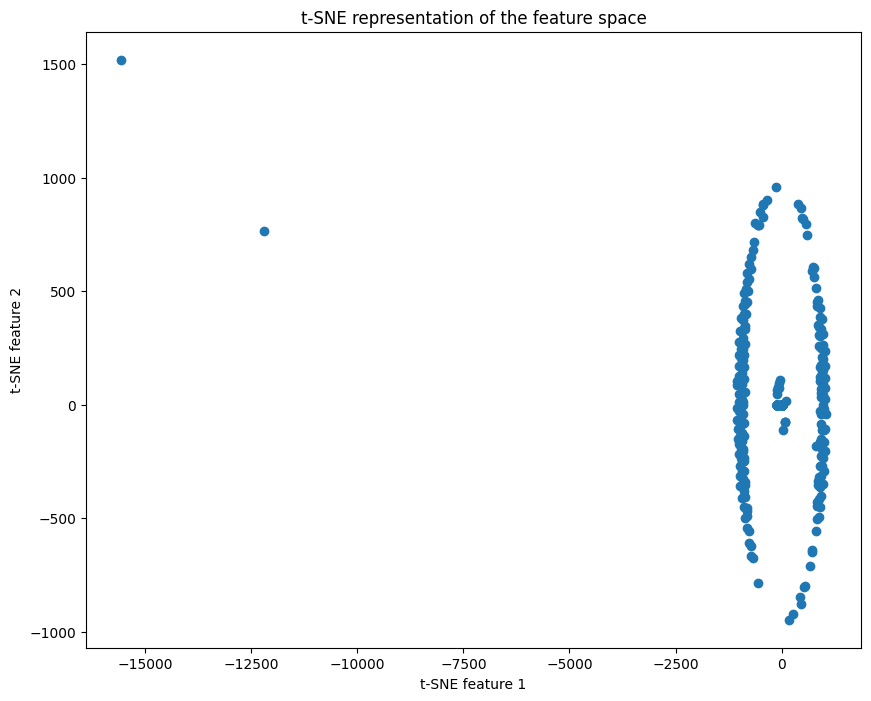

In [8]:
tsne = TSNE(n_components=2)  # n_components is the dimension of the embedded space
X_embedded = tsne.fit_transform(X)
X_embedded.shape

plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])  # Plot the first and second components
plt.title('t-SNE representation of the feature space')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

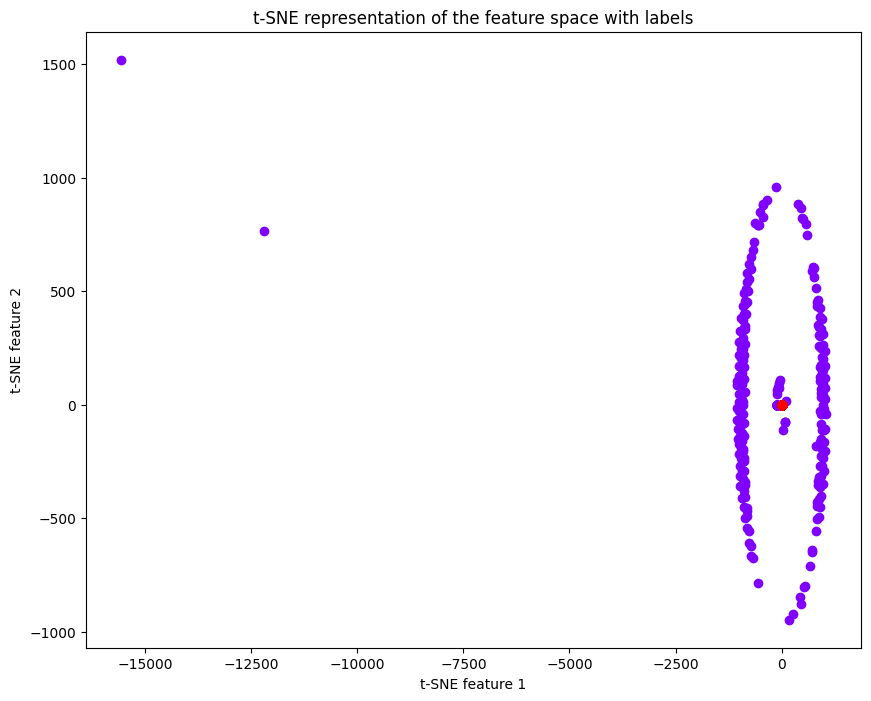

In [9]:

colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))

plt.figure(figsize=(10, 8))
idx = 50
for lab, col in zip(classes, colors):
    mask = labels == lab
    plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=lab, color=col)

plt.title('t-SNE representation of the feature space with labels')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
#plt.legend(loc='best')
plt.show()

In [10]:
print(np.min(labels))
print(np.max(labels))
print(np.argmin(labels))
print(np.argmax(labels))

np.count_nonzero(labels == 199)

0
199
0
99500


500

In [40]:
i = 20
k, j = i*10, i*10+10
print(X_embedded[k:j,:])
print(X_embedded[500,:])
print(X_embedded[9000,:] == X_embedded[500,:])

[[-116.79398      -0.25812668]
 [-116.79398      -0.25812668]
 [-116.79398      -0.25812668]
 [-116.79398      -0.25812668]
 [-116.79398      -0.25812668]
 [-116.79398      -0.25812668]
 [-116.79398      -0.25812668]
 [-116.79398      -0.25812668]
 [-116.79398      -0.25812668]
 [-116.79398      -0.25812668]]
[ 0.04338977 -0.08038209]
[ True  True]
